<a href="https://colab.research.google.com/github/akinahomwabella/fairml-xai-pipeline/blob/main/fairml-xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import and load libraries
!pip install lime
!pip install fairlearn
!pip install transformers accelerate
!pip install transformers accelerate bitsandbytes
!pip install --upgrade tensorflow
!pip install --upgrade tf_keras
!pip install --upgrade transformers
!pip install --upgrade shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lime.lime_tabular import LimeTabularExplainer
from sklearn.utils.class_weight import compute_sample_weight
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModelForCausalLM
import shap
import random
import lime
import lime.lime_tabular
import torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 68.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.49.0
    Uninstalling transformers-4.49.0:
      Successfully uninstalled transformers-4.49.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 972.6/972.6 kB 40.4 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.47.0
    Uninstalling shap-0.47.0:
      Successfully uninstalled shap-0.47.0


In [2]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path="/content/drive/MyDrive/NCUR"
if os.path.exists(path):
  files=[file for file in os.listdir(path) if not file.startswith('.')]
  for file in files:
    print(file)
else:
  print("Path doesn't exist")

adult.csv
compas-scores-two-years-violent.csv


In [5]:
# Load each dataset separately
#This dataset willl be on the COMPAS dataset
df_compas = pd.read_csv('/content/drive/MyDrive/NCUR/compas-scores-two-years-violent.csv')
df_compas.head()


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,1
2,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,0
3,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0
4,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,0


In [6]:
#Clean the COMPAS dataset(Pre-processing)
df_compas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4743 entries, 0 to 4742
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       4743 non-null   int64  
 1   name                     4743 non-null   object 
 2   first                    4743 non-null   object 
 3   last                     4743 non-null   object 
 4   compas_screening_date    4743 non-null   object 
 5   sex                      4743 non-null   object 
 6   dob                      4743 non-null   object 
 7   age                      4743 non-null   int64  
 8   age_cat                  4743 non-null   object 
 9   race                     4743 non-null   object 
 10  juv_fel_count            4743 non-null   int64  
 11  decile_score             4743 non-null   int64  
 12  juv_misd_count           4743 non-null   int64  
 13  juv_other_count          4743 non-null   int64  
 14  priors_count            

In [7]:
df_compas.describe(include='all')

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
count,4743.000000,4743,4743,4743,4743,4743,4743,4743.000000,4743,4743,...,4743,4743,4534,4534,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000
unique,NaN,4721,2114,2897,586,2,3978,NaN,3,6,...,3,586,1003,1012,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,james adams,michael,williams,2013-09-23,Male,1989-08-31,NaN,25 - 45,African-American,...,Low,2013-09-23,2014-01-04,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,95,49,24,3746,4,NaN,2699,2266,...,3389,24,19,27,NaN,NaN,NaN,NaN,NaN,NaN
mean,5454.230445,NaN,NaN,NaN,NaN,NaN,NaN,36.002952,NaN,NaN,...,NaN,NaN,NaN,NaN,2.677209,9.084124,730.143369,0.165507,0.163399,0.163399
std,3189.515451,NaN,NaN,NaN,NaN,NaN,NaN,12.200715,NaN,NaN,...,NaN,NaN,NaN,NaN,4.084277,36.867544,365.435158,0.371677,0.369768,0.369768
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2631.000000,NaN,NaN,NaN,NaN,NaN,NaN,26.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,422.500000,0.000000,0.000000,0.000000
50%,5475.000000,NaN,NaN,NaN,NaN,NaN,NaN,33.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000000,0.000000,837.000000,0.000000,0.000000,0.000000
75%,8239.500000,NaN,NaN,NaN,NaN,NaN,NaN,44.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,3.000000,1.000000,1039.000000,0.000000,0.000000,0.000000


In [8]:
#Clean the compas dataset
#Removing any column that is not needed
columns_to_drop = [
    'id', 'name', 'first', 'last', 'dob', 'violent_recid',
    'decile_score.1', 'priors_count.1', 'two_year_recid.1',
    'screening_date', 'v_screening_date', 'start', 'end', 'days_b_screening_arrest', 'c_days_from_compas', 'r_days_from_compas', 'c_days_b_screening', 'r_days_b_screening',
    'c_charge_degree', 'r_charge_degree', 'vr_charge_degree',
    'c_case_number', 'r_case_number', 'vr_case_number',
    'c_arrest_date', 'c_offense_date', 'r_offense_date', 'vr_offense_date',
    'c_jail_in', 'c_jail_out', 'r_jail_in', 'r_jail_out',
    'c_charge_desc', 'r_charge_desc', 'vr_charge_desc','compas_screening_date','age_cat','v_type_of_assessment','in_custody','out_custody','score_text','type_of_assessment','v_score_text','v_decile_score','event','is_violent_recid','is_recid',
]

# Remove whitespace(this helps if there is any space )
df_compas.columns = df_compas.columns.str.strip()
columns_to_drop = [col.strip() for col in columns_to_drop]


df_compas = df_compas.drop(columns=columns_to_drop, errors='ignore')

# Drop columns with too many NaNs:
df_compas = df_compas.dropna(axis=1, thresh=1000)

In [9]:
#Check whether the compas has duplicate or not
df_compas.duplicated().sum()

np.int64(1208)

In [10]:
#Drop the duplicates for the compas datsset
df_compas = df_compas.drop_duplicates()
df_compas.duplicated().sum()

np.int64(0)

In [11]:
df_compas.to_csv('cleaned_compas.csv',index=False) # to have permanent safe clean compas dataset
df_compas_cleaned = df_compas.copy() # work on this copy

In [12]:
df_compas_cleaned.info()
df_compas_cleaned.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
Index: 3535 entries, 0 to 4742
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sex              3535 non-null   object
 1   age              3535 non-null   int64 
 2   race             3535 non-null   object
 3   juv_fel_count    3535 non-null   int64 
 4   decile_score     3535 non-null   int64 
 5   juv_misd_count   3535 non-null   int64 
 6   juv_other_count  3535 non-null   int64 
 7   priors_count     3535 non-null   int64 
 8   two_year_recid   3535 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 276.2+ KB


,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,two_year_recid
count,3535,3535.000000,3535,3535.000000,3535.000000,3535.000000,3535.000000,3535.000000,3535.000000
unique,2,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN
top,Male,NaN,African-American,NaN,NaN,NaN,NaN,NaN,NaN
freq,2743,NaN,1748,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,36.089392,NaN,0.060255,4.468175,0.094767,0.106931,3.385856,0.210184
std,NaN,12.231609,NaN,0.485840,2.802102,0.467765,0.538706,4.469531,0.407497
min,NaN,18.000000,NaN,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,26.000000,NaN,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,33.000000,NaN,0.000000,4.000000,0.000000,0.000000,2.000000,0.000000
75%,NaN,44.000000,NaN,0.000000,7.000000,0.000000,0.000000,5.000000,0.000000


In [13]:
#Encoding the COMPAS dataset next
# map the encoding to figure out which we will use during fairness analysis
race_mapping = {
    'African-American': 0,
    'Asian': 1,
    'Caucasian': 2,
    'Hispanic': 3,
    'Native American': 4,
    'Other': 5
}
sex_mapping = {'Female': 0, 'Male':1 }
#Add the encoded program into the dataset
df_compas_cleaned['race_encoded'] = df_compas_cleaned['race'].map(race_mapping)
df_compas_cleaned['sex_encoded'] = df_compas_cleaned['sex'].map(sex_mapping)



#Save a csv with an encoded dataset
df_compas_cleaned.to_csv('encoded_compas.csv', index=False)
df_compas_encoded = df_compas_cleaned.copy()
df_compas_encoded.head()

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,two_year_recid,race_encoded,sex_encoded
0,Male,69,Other,0,1,0,0,0,0,5,1
1,Male,34,African-American,0,3,0,0,0,1,0,1
2,Male,23,African-American,0,8,1,0,1,0,0,1
3,Male,43,Other,0,1,0,0,2,0,5,1
4,Male,44,Other,0,1,0,0,0,0,5,1


In [14]:
#Check if they are actually encoded or not
df_compas_encoded['sex_encoded'].unique()

array([1, 0])

In [15]:
df_compas_encoded['race_encoded'].unique()

array([5, 0, 2, 3, 1, 4])

In [16]:
#Split the dataset into to train and test split
#Perform logisitc regression on compas dataset
X_compas=df_compas_encoded.drop(columns=['two_year_recid','race','sex'])
Y_compas=df_compas_encoded['two_year_recid']
X_train_compas,X_test_compas,Y_train_compas,Y_test_compas=train_test_split(X_compas,Y_compas,test_size=0.2,random_state=42)
model_lr=LogisticRegression(max_iter=1000)
model_lr.fit(X_train_compas,Y_train_compas)
y_pred_lg=model_lr.predict(X_test_compas)


In [17]:
#Evaluate the performance
print(classification_report(Y_test_compas,y_pred_lg))
print(confusion_matrix(Y_test_compas,y_pred_lg))


              precision    recall  f1-score   support

           0       0.80      0.98      0.88       553
           1       0.59      0.11      0.19       154

    accuracy                           0.79       707
   macro avg       0.69      0.54      0.53       707
weighted avg       0.75      0.79      0.73       707

[[541  12]
 [137  17]]


In [18]:
#Perform random forest classifier(try another model too)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_compas, Y_train_compas)
y_pred_rf = rf.predict(X_test_compas)

#Evaluate the performance
print(classification_report(Y_test_compas,y_pred_rf))
print(confusion_matrix(Y_test_compas,y_pred_rf))


              precision    recall  f1-score   support

           0       0.80      0.88      0.84       553
           1       0.33      0.22      0.26       154

    accuracy                           0.73       707
   macro avg       0.57      0.55      0.55       707
weighted avg       0.70      0.73      0.71       707

[[484  69]
 [120  34]]


In [19]:
#Fairness check with the Random Forest Classifier for race
X_test_compas_copy=X_test_compas.copy()
X_test_compas_copy['true'] = Y_test_compas
X_test_compas_copy['pred'] = y_pred_rf
X_test_compas_copy['race'] = df_compas_cleaned.loc[X_test_compas.index, 'race']

#Check false positive by Race
# False Positives by race
fp_by_compas_race = X_test_compas_copy[(X_test_compas_copy['true'] == 0) & (X_test_compas_copy['pred'] == 1)].race.value_counts(normalize=True)
print(fp_by_compas_race)

# False Negatives by race
fn_by_compas_race = X_test_compas_copy[(X_test_compas_copy['true'] == 1) & (X_test_compas_copy['pred'] == 0)].race.value_counts(normalize=True)
print(fn_by_compas_race)

race
African-American    0.666667
Caucasian           0.304348
Asian               0.014493
Hispanic            0.014493
Name: proportion, dtype: float64
race
African-American    0.500000
Caucasian           0.275000
Other               0.100000
Hispanic            0.100000
Native American     0.016667
Asian               0.008333
Name: proportion, dtype: float64


In [20]:
#Fairness check with the Random Forest Classifier for sex
X_test_compas_copy['true'] = Y_test_compas
X_test_compas_copy['pred'] = y_pred_rf
X_test_compas_copy['sex'] = df_compas_cleaned.loc[X_test_compas.index, 'sex']

#Check false positive by sex
# False Positives by sex
fp_by_compas_sex = X_test_compas_copy[(X_test_compas_copy['true'] == 0) & (X_test_compas_copy['pred'] == 1)].sex.value_counts(normalize=True)
print(fp_by_compas_sex)

# False Negatives by sex
fn_by_compas_sex = X_test_compas_copy[(X_test_compas_copy['true'] == 1) & (X_test_compas_copy['pred'] == 0)].sex.value_counts(normalize=True)
print(fn_by_compas_sex)

sex
Male      0.898551
Female    0.101449
Name: proportion, dtype: float64
sex
Male      0.866667
Female    0.133333
Name: proportion, dtype: float64


In [21]:
# To make sure that maybe the datasey has more male than female or not
#calculate tpr,fpr,fnr,tnr
# Get unique sex values
sex_groups = X_test_compas_copy['sex'].unique()

# Dictionaries to store FPR and FNR
fpr_dict = {}
fnr_dict = {}

for sex in sex_groups:
    group = X_test_compas_copy[X_test_compas_copy['sex'] == sex]

    # Confusion matrix components
    TP = ((group['true'] == 1) & (group['pred'] == 1)).sum()
    TN = ((group['true'] == 0) & (group['pred'] == 0)).sum()
    FP = ((group['true'] == 0) & (group['pred'] == 1)).sum()
    FN = ((group['true'] == 1) & (group['pred'] == 0)).sum()

    # Calculate FPR and FNR
    fpr = FP / (FP + TN) if (FP + TN) != 0 else 0
    fnr = FN / (FN + TP) if (FN + TP) != 0 else 0

    # Store
    fpr_dict[sex] = fpr
    fnr_dict[sex] = fnr

print("False Positive Rate (FPR) per sex:", fpr_dict)
print("False Negative Rate (FNR) per sex:", fnr_dict)


False Positive Rate (FPR) per sex: {'Female': np.float64(0.04964539007092199), 'Male': np.float64(0.15048543689320387)}
False Negative Rate (FNR) per sex: {'Female': np.float64(0.8421052631578947), 'Male': np.float64(0.7703703703703704)}


 97%|=================== | 1366/1414 [00:20<00:00]       

SHAP values for class 1 shape: (707, 8)


<ipython-input-22-1e71f4cbfaee>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='feature', y='shap_value', data=shap_melted_compas, ci=None)


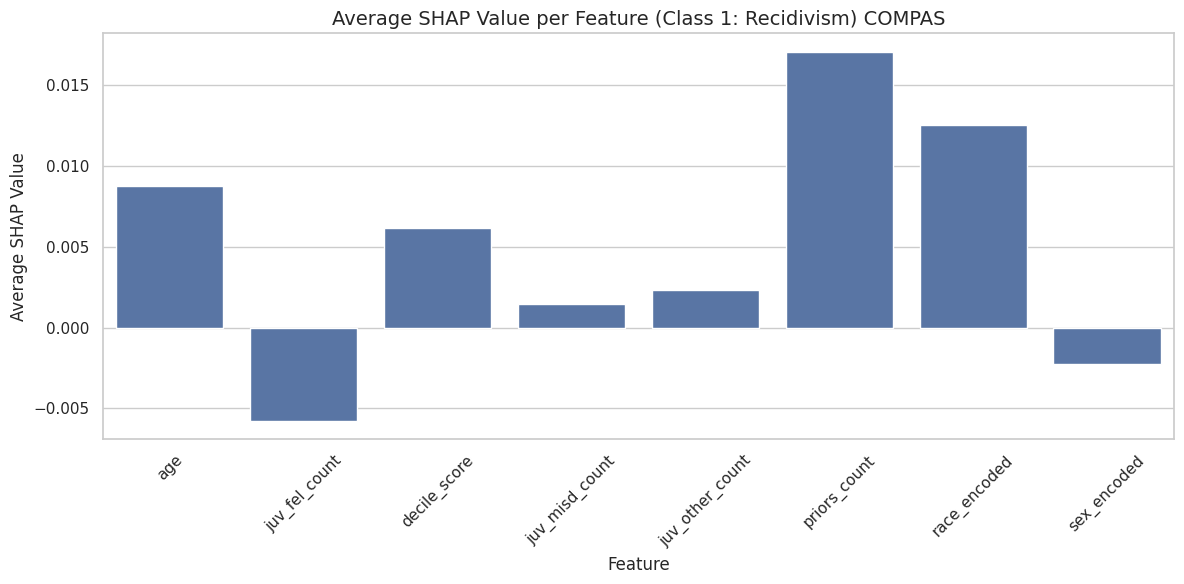

In [22]:
#SHAP value for COMPAS_dataset
# Sample background data from training set
background = X_train_compas.sample(30, random_state=42)

# Initialize TreeExplainer with background data
explainer = shap.TreeExplainer(rf, data=background, model_output='probability')
shap_values = explainer.shap_values(X_test_compas)

# Extract the SHAP values for class 1 (Recidivism) for all samples
shap_values_class1 = np.array([sv[:, 1] for sv in shap_values])
print("SHAP values for class 1 shape:", shap_values_class1.shape)

# Convert the extracted SHAP values to a dataframe with the same columns as X_test_compas
shap_df_compas= pd.DataFrame(shap_values_class1, columns=X_test_compas.columns)
shap_df_compas['sample_id'] = shap_df_compas.index

# Melt the DataFrame into long format for plotting
shap_melted_compas= shap_df_compas.melt(id_vars='sample_id', var_name='feature', value_name='shap_value')

# Plot a bar plot of the SHAP values for each feature
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(x='feature', y='shap_value', data=shap_melted_compas, ci=None)

plt.title('Average SHAP Value per Feature (Class 1: Recidivism) COMPAS', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average SHAP Value', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
#Use LIME Explainer to understand locally
import random
from lime.lime_tabular import LimeTabularExplainer

# Create an instance for LIME Explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_compas),
    feature_names=X_train_compas.columns.tolist(),
    class_names=['No Recidivism', 'Recidivism'],
    mode='classification'
)
#List to collect data
lime_data=[]
# Loop through 30 random samples from X_test_compas
for i in random.sample(range(len(X_test_compas)), 30):
    exp = explainer.explain_instance(
        data_row=X_test_compas.iloc[i],
        predict_fn=rf.predict_proba,
        num_features=5
    )
    for feature,weight in exp.as_list():
        lime_data.append([i,feature,weight])

# Convert to DataFrame
lime_df = pd.DataFrame(lime_data, columns=['sample_id', 'feature', 'lime_weight'])



/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

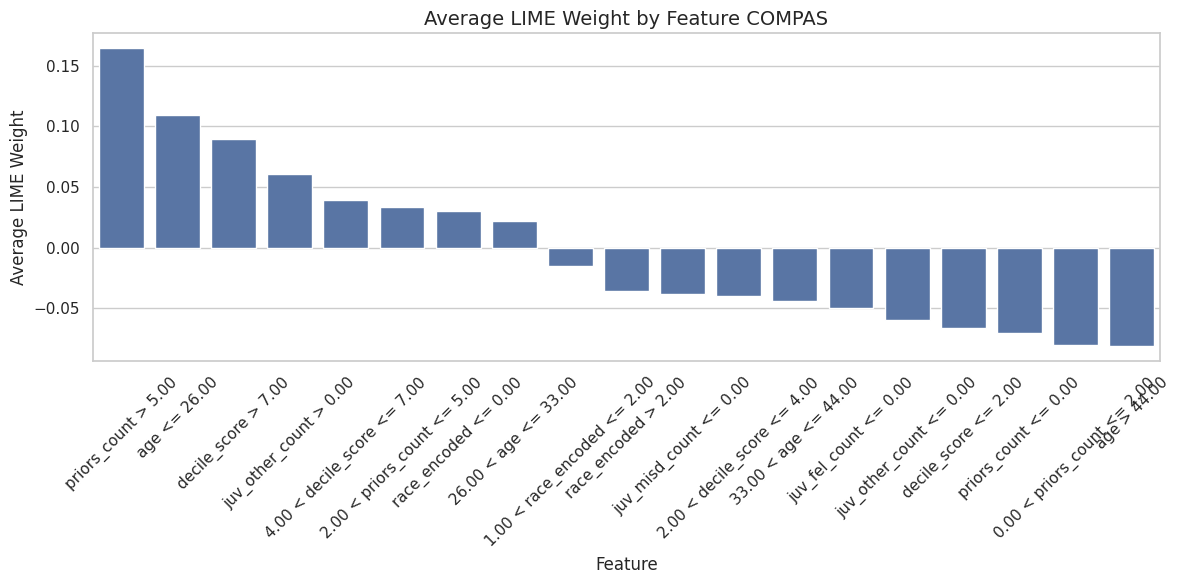

In [24]:
#Make bar plot of Average LIME Weights(since we want to average it rather than making graaph for each local model)
#calculate the average LIME weight per feature
avg_weights_compas=lime_df.groupby('feature')['lime_weight'].mean().reset_index()
# sort by weight
avg_weights_compas=avg_weights_compas.sort_values(by='lime_weight',ascending=False)
#plot
plt.figure(figsize=(12,6))
sns.barplot(x='feature',y='lime_weight',data=avg_weights_compas)
plt.title('Average LIME Weight by Feature COMPAS', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average LIME Weight', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [25]:
#Rewighing the class to improve the class imbalance for better prediction
# Calculate sample weights for class balance
sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train_compas)

# Initialize Random Forest
rf_reweighted = RandomForestClassifier(max_depth=3, random_state=42)

# Fit with reweighting
rf_reweighted.fit(X_train_compas, Y_train_compas, sample_weight=sample_weights)

# Predict & evaluate
y_pred_rw_compas = rf_reweighted.predict(X_test_compas)
print("Reweighted Random Forest Model:")
print(classification_report(Y_test_compas, y_pred_rw_compas))
print(confusion_matrix(Y_test_compas, y_pred_rw_compas))

Reweighted Random Forest Model:
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       553
           1       0.36      0.60      0.45       154

    accuracy                           0.68       707
   macro avg       0.61      0.65      0.61       707
weighted avg       0.75      0.68      0.70       707

[[388 165]
 [ 62  92]]


In [26]:
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds


# Fairlearn base model -Equalized ODDS
fair_base_model = RandomForestClassifier(random_state=42)

# Fairlearn constraint setup
fairlearn_copy = ExponentiatedGradient(estimator=fair_base_model, constraints=EqualizedOdds())

# Fit Fairlearn on the original data (to not affect reweighted model)
fairlearn_copy.fit(X_train_compas, Y_train_compas, sensitive_features=X_train_compas['race_encoded'])

# Predict with Fairlearn copy for auditing ONLY
y_pred_fair_copy = fairlearn_copy.predict(X_test_compas)
print("Fairlearn Mitigated Model (Copy for Comparison):")
print(classification_report(Y_test_compas, y_pred_fair_copy))
print(confusion_matrix(Y_test_compas, y_pred_fair_copy))


Fairlearn Mitigated Model (Copy for Comparison):
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       553
           1       0.31      0.19      0.24       154

    accuracy                           0.73       707
   macro avg       0.55      0.54      0.54       707
weighted avg       0.69      0.73      0.71       707

[[487  66]
 [124  30]]


In [27]:
import shap

# SHAP for reweighing
# Ensure background data comes from dataset as the test data
background_compas = X_train_compas.sample(30, random_state=42).astype(float)
X_test_compas_float = X_test_compas.astype(float)

# SHAP Explainer

explainer = shap.Explainer(rf_reweighted, background_compas)
shap_values = explainer(X_test_compas_float)

# Extract SHAP values for class 1 (index 1)
shap_array = shap_values.values[:, :, 1]  # Shape: [707, 8]

# Create wide-format DataFrame
shap_df_compas = pd.DataFrame(shap_array, columns=X_test_compas.columns)

# Add sample IDs for reference
shap_df_compas['sample_id'] = shap_df_compas.index

# Save wide format CSV
shap_df_compas.to_csv("shap_values_compas_wide.csv", index=False)
print("SHAP values saved (wide format) to shap_values_compas_wide.csv")

# Melt to long format for bar plot or analysis
shap_melted_compas = shap_df_compas.melt(id_vars='sample_id', var_name='feature', value_name='shap_value')

# Save melted format CSV
shap_melted_compas.to_csv("shap_values_compas_long.csv", index=False)
print("SHAP values saved (long format) to shap_values_compas_long.csv")



SHAP values saved (wide format) to shap_values_compas_wide.csv
SHAP values saved (long format) to shap_values_compas_long.csv


<ipython-input-28-22f763e13d0a>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='feature', y='shap_value', data=shap_melted_compas, ci=None)


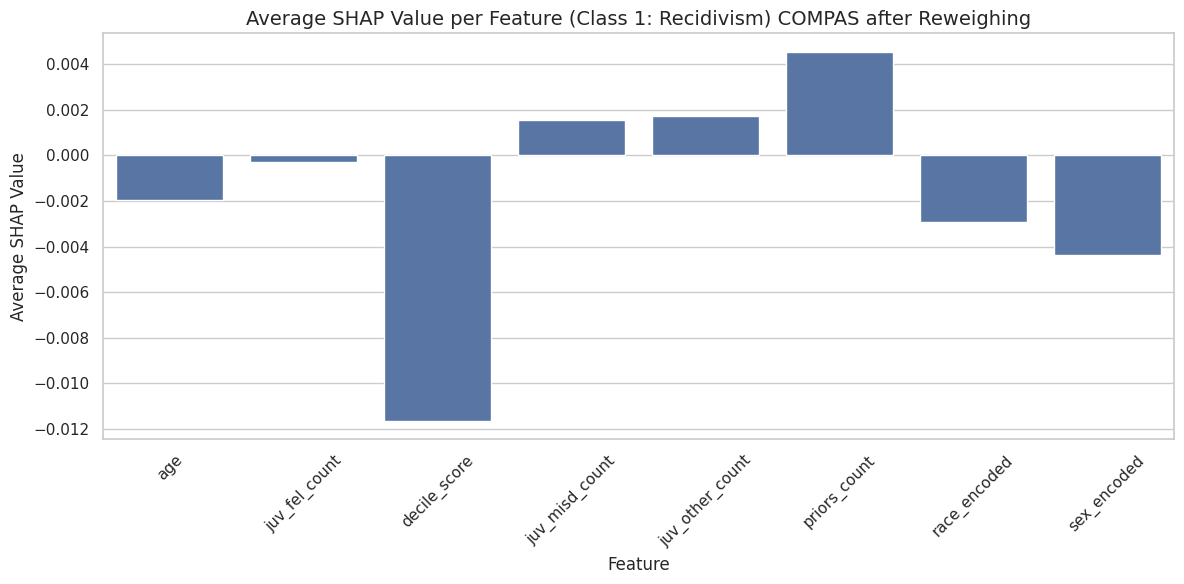

In [28]:

# Plot a bar plot of the SHAP values for each feature
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(x='feature', y='shap_value', data=shap_melted_compas, ci=None)

plt.title('Average SHAP Value per Feature (Class 1: Recidivism) COMPAS after Reweighing', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average SHAP Value', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

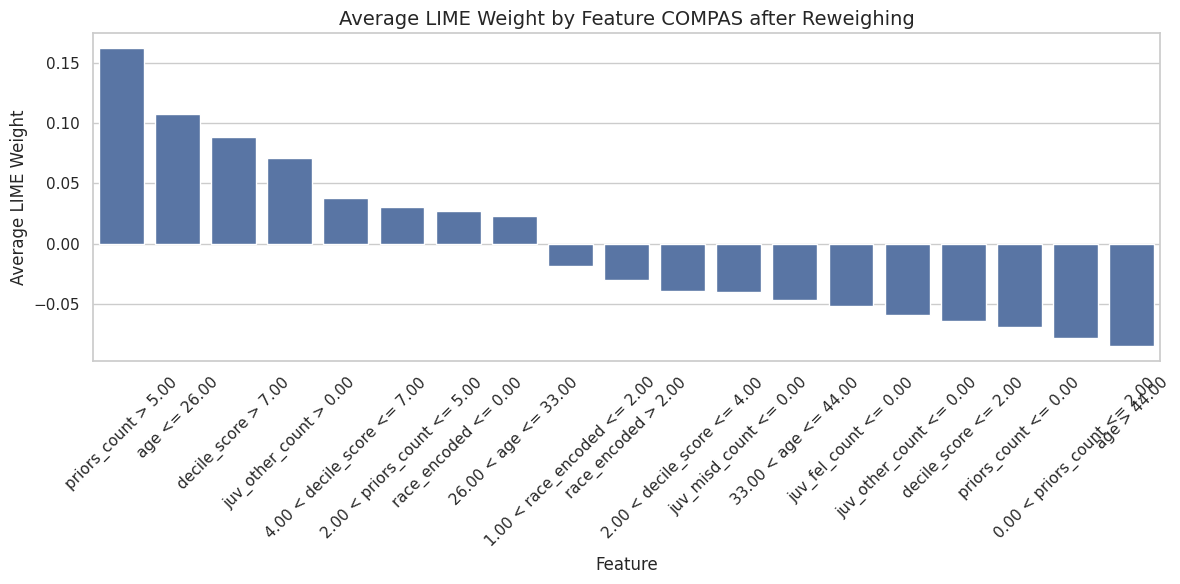

In [29]:
import random
from lime.lime_tabular import LimeTabularExplainer

# Create an instance for LIME Explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_compas),
    feature_names=X_train_compas.columns.tolist(),
    class_names=['No Recidivism', 'Recidivism'],
    mode='classification'
)
#List to collect data
lime_data=[]
# Loop through 30 random samples from X_test_compas
for i in random.sample(range(len(X_test_compas)), 30):
    exp = explainer.explain_instance(
        data_row=X_test_compas.iloc[i],
        predict_fn=rf.predict_proba,
        num_features=5
    )
    for feature,weight in exp.as_list():
        lime_data.append([i,feature,weight])

# Convert to DataFrame
lime_df = pd.DataFrame(lime_data, columns=['sample_id', 'feature', 'lime_weight'])
#Make bar plot of Average LIME Weights
#calculate the average LIME weight per feature
avg_weights_compas=lime_df.groupby('feature')['lime_weight'].mean().reset_index()
# sort by weight
avg_weights_compas=avg_weights_compas.sort_values(by='lime_weight',ascending=False)
#plot
plt.figure(figsize=(12,6))
sns.barplot(x='feature',y='lime_weight',data=avg_weights_compas)
plt.title('Average LIME Weight by Feature COMPAS after Reweighing', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average LIME Weight', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
#Load the adult dataset
df_adult = pd.read_csv('/content/drive/MyDrive/NCUR/adult.csv')
df_adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [31]:
#Read the adult.csv file
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [32]:
df_adult.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [33]:
columns_to_drop_adult=['fnlwgt','capital-gain','capital-loss','native-country','education','relationship']
df_adult=df_adult.drop(columns=columns_to_drop_adult)

In [34]:
#Check for duplicates before dropping it
df_adult.duplicated().sum()

np.int64(10364)

In [35]:
#Drop the duplicates
df_adult = df_adult.drop_duplicates()
df_adult.duplicated().sum()

np.int64(0)

In [36]:
df_adult.to_csv('cleaned_adult.csv',index=False)
df_adult_cleaned = df_adult.copy()

In [37]:
df_adult_cleaned.info()
df_adult_cleaned.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
Index: 38478 entries, 0 to 48841
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              38478 non-null  int64 
 1   workclass        38478 non-null  object
 2   educational-num  38478 non-null  int64 
 3   marital-status   38478 non-null  object
 4   occupation       38478 non-null  object
 5   race             38478 non-null  object
 6   gender           38478 non-null  object
 7   hours-per-week   38478 non-null  int64 
 8   income           38478 non-null  object
dtypes: int64(3), object(6)
memory usage: 2.9+ MB


,age,workclass,educational-num,marital-status,occupation,race,gender,hours-per-week,income
count,38478.000000,38478,38478.000000,38478,38478,38478,38478,38478.000000,38478
unique,NaN,9,NaN,7,15,5,2,NaN,2
top,NaN,Private,NaN,Married-civ-spouse,Prof-specialty,White,Male,NaN,<=50K
freq,NaN,24833,NaN,17616,5213,31796,25311,NaN,29087
mean,40.034617,NaN,10.078902,NaN,NaN,NaN,NaN,40.701102,NaN
std,13.871053,NaN,2.706802,NaN,NaN,NaN,NaN,13.295617,NaN
min,17.000000,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN
25%,29.000000,NaN,9.000000,NaN,NaN,NaN,NaN,38.000000,NaN
50%,39.000000,NaN,10.000000,NaN,NaN,NaN,NaN,40.000000,NaN
75%,49.000000,NaN,13.000000,NaN,NaN,NaN,NaN,45.000000,NaN


In [38]:
# Check for any '?' entries
for col in df_adult_cleaned.columns:
    print(f"{col}: {(df_adult_cleaned[col] == '?').sum()} ")
# Count '?' in workclass and occupation by gender
for col in ['workclass', 'occupation']:
    # Filter the DataFrame for rows where the specified column has '?'
    missing_rows = df_adult_cleaned[df_adult_cleaned[col] == '?']
    # Get the value counts of 'gender' in the filtered rows
    missing_by_gender = missing_rows['gender'].value_counts()
    print(f"\nMissing '{col}' entries by gender:\n{missing_by_gender}")


age: 0 
workclass: 2234 
educational-num: 0 
marital-status: 0 
occupation: 2244 
race: 0 
gender: 0 
hours-per-week: 0 
income: 0 

Missing 'workclass' entries by gender:
gender
Male      1212
Female    1022
Name: count, dtype: int64

Missing 'occupation' entries by gender:
gender
Male      1219
Female    1025
Name: count, dtype: int64


In [39]:
#Drop the workclass and occupation columns since the difference is negligible in gender
columns_to_drop_adult=['workclass','occupation']
df_adult_cleaned=df_adult_cleaned.drop(columns=columns_to_drop_adult)
print(df_adult_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 38478 entries, 0 to 48841
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              38478 non-null  int64 
 1   educational-num  38478 non-null  int64 
 2   marital-status   38478 non-null  object
 3   race             38478 non-null  object
 4   gender           38478 non-null  object
 5   hours-per-week   38478 non-null  int64 
 6   income           38478 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.3+ MB
None


In [40]:
#Encoding the adult dataset next
#Make a copy of the cleaned adult
df_adult_cleaned=df_adult_cleaned.copy()

#map the encoding to use fairness analysis

gender_mapping={'Female':0,'Male':1}
income_mapping={'<=50K':0,'>50K':1}

race_mapping_adult = {
    'Black': 0,
    'White': 1,
    'Asian-Pac-Islander': 2,
    'Amer-Indian-Eskimo': 3,
    'Other': 4
}

df_adult_cleaned['gender_encoded']=df_adult_cleaned['gender'].map(gender_mapping)
df_adult_cleaned['income_encoded']=df_adult_cleaned['income'].map(income_mapping)
df_adult_cleaned['race_encoded']=df_adult_cleaned['race'].map(race_mapping_adult)

#One-Hot Encoding multi-class categorical columns
df_adult_cleaned=pd.get_dummies(df_adult_cleaned,columns=['marital-status'])

df_adult_cleaned.to_csv('adult_encoded.csv', index=False)
df_adult_encoded = df_adult_cleaned.copy()
df_adult_encoded.head()

,age,educational-num,race,gender,hours-per-week,income,gender_encoded,income_encoded,race_encoded,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed
0,25,7,Black,Male,40,<=50K,1,0,0,False,False,False,False,True,False,False
1,38,9,White,Male,50,<=50K,1,0,1,False,False,True,False,False,False,False
2,28,12,White,Male,40,>50K,1,1,1,False,False,True,False,False,False,False
3,44,10,Black,Male,40,>50K,1,1,0,False,False,True,False,False,False,False
4,18,10,White,Female,30,<=50K,0,0,1,False,False,False,False,True,False,False


In [41]:
#Check if they are actually encoded or not
df_adult_encoded['gender_encoded'].unique()

array([1, 0])

In [42]:
df_adult_encoded['income_encoded'].unique()

array([0, 1])

In [43]:
df_adult_encoded['race_encoded'].unique()

array([0, 1, 2, 4, 3])

In [44]:
#Split the dataset into to train and test split then train
#Perform logisitc regression on adult dataset
X_adult=df_adult_encoded.drop(columns=['income','race','gender','income_encoded'])
Y_adult=df_adult_encoded['income_encoded']
X_train_adult,X_test_adult,Y_train_adult,Y_test_adult=train_test_split(X_adult,Y_adult,test_size=0.2,random_state=42)
model_lr=LogisticRegression(max_iter=1000)
model_lr.fit(X_train_adult,Y_train_adult)
y_pred_lg=model_lr.predict(X_test_adult)

In [45]:
#Evaluate the performance
print(classification_report(Y_test_adult,y_pred_lg))
print(confusion_matrix(Y_test_adult,y_pred_lg))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      5813
           1       0.65      0.45      0.53      1883

    accuracy                           0.80      7696
   macro avg       0.74      0.68      0.70      7696
weighted avg       0.79      0.80      0.79      7696

[[5352  461]
 [1042  841]]


In [46]:
#Train the model with XGBoost Classifier
X_adult=df_adult_encoded.drop(columns=['income','race','gender','income_encoded'])
Y_adult=df_adult_encoded['income_encoded']
X_train_adult,X_test_adult,Y_train_adult,Y_test_adult=train_test_split(X_adult,Y_adult,test_size=0.2,random_state=42)
model_xg=XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, random_state=42)
model_xg.fit(X_train_adult,Y_train_adult)
y_pred_xg=model_xg.predict(X_test_adult)

In [47]:
#Evaluate the performance fo xg booster
print(classification_report(Y_test_adult,y_pred_xg))
print(confusion_matrix(Y_test_adult,y_pred_xg))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89      5813
           1       0.68      0.50      0.58      1883

    accuracy                           0.82      7696
   macro avg       0.76      0.71      0.73      7696
weighted avg       0.81      0.82      0.81      7696

[[5356  457]
 [ 933  950]]


In [48]:
#Fairness check with the XG Booster Classifier for race
X_test_adult_copy=X_test_adult.copy()
X_test_adult_copy['true'] = Y_test_adult
X_test_adult_copy['pred'] = y_pred_xg
X_test_adult_copy['race'] = df_adult_cleaned.loc[X_test_adult.index, 'race']

#Check false positive by Race
# False Positives by race
fp_by_adult_race = X_test_adult_copy[(X_test_adult_copy['true'] == 0) & (X_test_adult_copy['pred'] == 1)].race.value_counts(normalize=True)
print(fp_by_adult_race)

# False Negatives by race
fn_by_adult_race = X_test_adult_copy[(X_test_adult_copy['true'] == 1) & (X_test_adult_copy['pred'] == 0)].race.value_counts(normalize=True)
print(fn_by_adult_race)

race
White                 0.945295
Asian-Pac-Islander    0.030635
Black                 0.024070
Name: proportion, dtype: float64
race
White                 0.879957
Black                 0.070740
Asian-Pac-Islander    0.035370
Amer-Indian-Eskimo    0.007503
Other                 0.006431
Name: proportion, dtype: float64


In [49]:
#Fairness check with the XG Booster Classifier for gender
X_test_adult_copy=X_test_adult.copy()
X_test_adult_copy['true'] = Y_test_adult
X_test_adult_copy['pred'] = y_pred_xg
X_test_adult_copy['gender'] = df_adult_cleaned.loc[X_test_adult.index, 'gender']

#Check false positive by Gender
# False Positives by Gender
fp_by_adult_gender = X_test_adult_copy[(X_test_adult_copy['true'] == 0) & (X_test_adult_copy['pred'] == 1)].gender.value_counts(normalize=True)
print(fp_by_adult_gender)

# False Negatives by gender
fn_by_adult_gender = X_test_adult_copy[(X_test_adult_copy['true'] == 1) & (X_test_adult_copy['pred'] == 0)].gender.value_counts(normalize=True)
print(fn_by_adult_gender)

gender
Male      0.890591
Female    0.109409
Name: proportion, dtype: float64
gender
Male      0.771704
Female    0.228296
Name: proportion, dtype: float64


In [50]:
#Since the datset might have more White race and fewer female gender too check using fnr and fpr
#To check how often model make errors relative to number if opportunities
total_negatives_gender = X_test_adult_copy[X_test_adult_copy['true'] == 0]['gender'].value_counts()
total_positives_gender = X_test_adult_copy[X_test_adult_copy['true'] == 1]['gender'].value_counts()

fp_counts_gender = X_test_adult_copy[(X_test_adult_copy['true'] == 0) & (X_test_adult_copy['pred'] == 1)]['gender'].value_counts()
fn_counts_gender = X_test_adult_copy[(X_test_adult_copy['true'] == 1) & (X_test_adult_copy['pred'] == 0)]['gender'].value_counts()

fp_rate_gender = fp_counts_gender / total_negatives_gender
fn_rate_gender = fn_counts_gender / total_positives_gender

print("FP Rate by Gender:\n", fp_rate_gender)
print("FN Rate by Gender:\n", fn_rate_gender)

FP Rate by Gender:
 gender
Male      0.117494
Female    0.021286
Name: count, dtype: float64
FN Rate by Gender:
 gender
Male      0.472441
Female    0.593315
Name: count, dtype: float64


(7696, 12)
(12,)


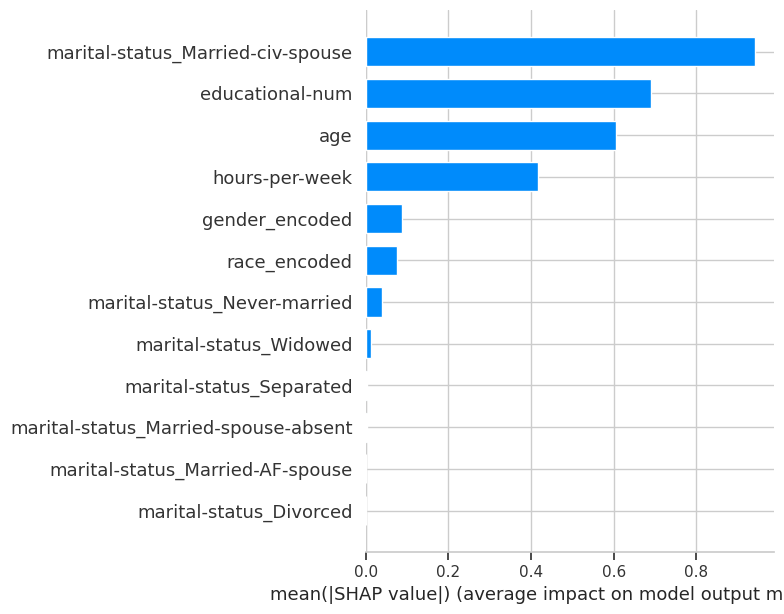

In [51]:
#Work on the SHAP values for the adult dataset
# Sample background data
background_adult = X_train_adult.sample(30, random_state=42).astype(float)
X_test_adult_float = X_test_adult.astype(float)

# Initialize SHAP Explainer (auto-detect TreeExplainer)
explainer = shap.Explainer(model_xg, background_adult)

# Compute SHAP values (returns Explanation object)
shap_values = explainer(X_test_adult_float)

# Extract SHAP values (shape: n_samples x n_features)
shap_values_class1_adult = shap_values.values

# Confirm shapes match for DataFrame
print(shap_values_class1_adult.shape)
print(X_test_adult.columns.shape)

# Convert to DataFrame
shap_df_adult = pd.DataFrame(shap_values_class1_adult, columns=X_test_adult.columns)
shap_df_adult['sample_id'] = shap_df_adult.index

# Melt for seaborn plot
shap_melted_adult = shap_df_adult.melt(id_vars='sample_id', var_name='feature', value_name='shap_value')
# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_adult, plot_type="bar", show=True)


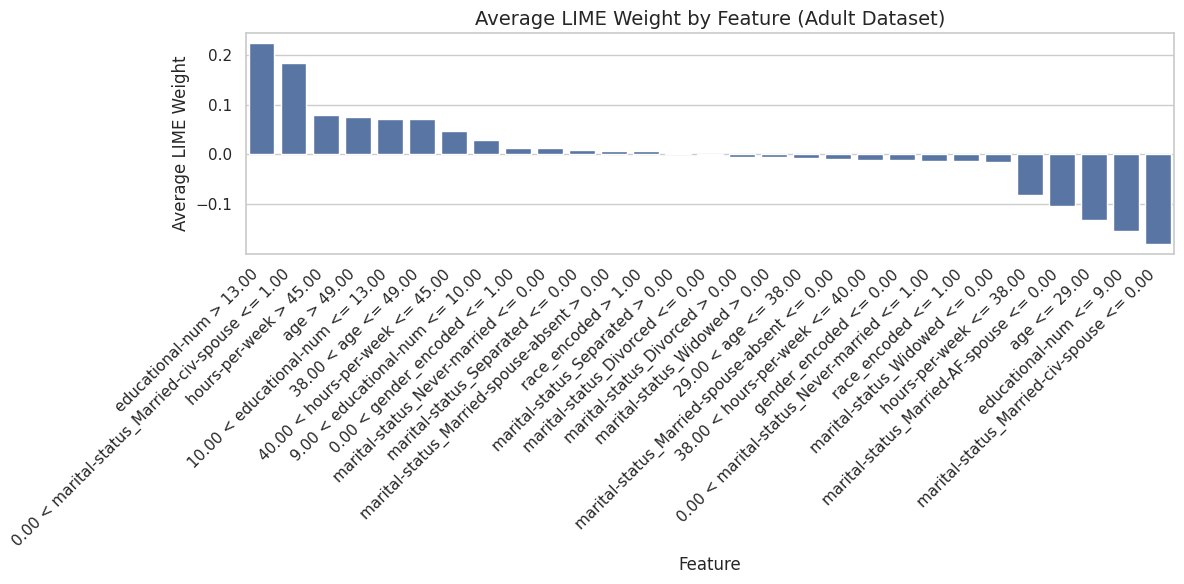

In [52]:
#Apply the LIME for adult dataset too
# Convert to numpy arrays
X_train_np = X_train_adult.values
X_test_np = X_test_adult.values
feature_names = X_train_adult.columns.tolist()
class_names = ['<=50K', '>50K']

# Initialize LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

# All the LIME weights into a list
lime_weights_list = []

# Loop over samples from test set
N = 30
for i in range(N):
    exp = explainer.explain_instance(
        data_row=X_test_np[i],
        predict_fn=model_xg.predict_proba,
        num_features=10
    )

    # Get explanation
    for feature, weight in exp.as_list():
        lime_weights_list.append({'feature': feature, 'lime_weight': weight})

# Convert to DataFrame
lime_df = pd.DataFrame(lime_weights_list)

# Group by feature and calculate average weight
avg_weights_adult = lime_df.groupby('feature')['lime_weight'].mean().reset_index()
avg_weights_adult = avg_weights_adult.sort_values(by='lime_weight', ascending=False)

# Plot average LIME weight per feature
plt.figure(figsize=(12, 6))
sns.barplot(x='feature', y='lime_weight', data=avg_weights_adult)
plt.title('Average LIME Weight by Feature (Adult Dataset)', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average LIME Weight', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [53]:
#Reweighing for the ADULT dataset
# Calculate sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train_adult)

# Fit model with sample weights
model_xg_reweighted = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, random_state=42)
model_xg_reweighted.fit(X_train_adult, Y_train_adult, sample_weight=sample_weights)

# Predict and Evaluate
y_pred_rw = model_xg_reweighted.predict(X_test_adult)
print("Reweighted Model for Adult dataset:")
print(classification_report(Y_test_adult, y_pred_rw))


Reweighted Model for Adult dataset:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      5813
           1       0.51      0.83      0.63      1883

    accuracy                           0.77      7696
   macro avg       0.72      0.79      0.73      7696
weighted avg       0.83      0.77      0.78      7696



In [54]:
#Fairlearn Model for Adult dataset
fair_base_model_copy = LogisticRegression(max_iter=1000)
fairlearn_copy = ExponentiatedGradient(
    estimator=fair_base_model_copy,
    constraints=EqualizedOdds()
)

fairlearn_copy.fit(
    X_train_compas,
    Y_train_compas,
    sensitive_features=X_train_compas['race_encoded']
)

# for evaluation only
y_pred_fair_copy = fairlearn_copy.predict(X_test_compas)

# Evaluate performance (ONLY for comparison)
print("Fairlearn Mitigated Model (Copy for Comparison):")
print(classification_report(Y_test_compas, y_pred_fair_copy))
print(confusion_matrix(Y_test_compas, y_pred_fair_copy))

Fairlearn Mitigated Model (Copy for Comparison):
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       553
           1       0.36      0.05      0.09       154

    accuracy                           0.77       707
   macro avg       0.58      0.51      0.48       707
weighted avg       0.69      0.77      0.70       707

[[539  14]
 [146   8]]


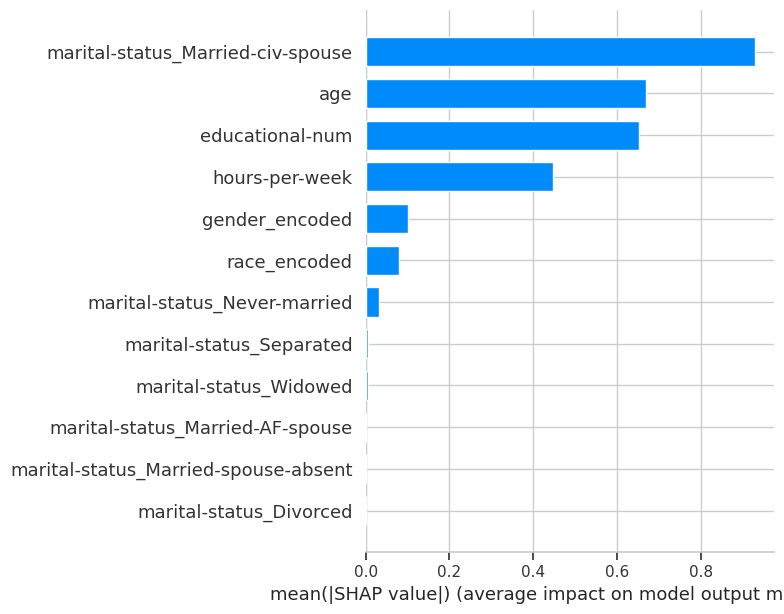

In [55]:
#SHAP after reweighing the values for Adult dataset

# Background for SHAP
background_adult = X_train_adult.sample(50, random_state=42).astype(float)
X_test_adult_float = X_test_adult.astype(float)

# SHAP Explainer after Reweighing
explainer = shap.Explainer(model_xg_reweighted, background_adult)
shap_values = explainer(X_test_adult_float)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_adult, plot_type="bar", show=True)


In [56]:
#Save reweighted SHAP values in dataframe then csv for later
import pandas as pd

# Extract SHAP values (matrix)
shap_array = shap_values.values  # shape: [num_samples, num_features]

# Convert to DataFrame with feature names
shap_df = pd.DataFrame(shap_array, columns=X_test_adult.columns)

# Optional: Add prediction and true labels for context
shap_df["prediction"] = model_xg_reweighted.predict(X_test_adult)
shap_df["true_label"] = Y_test_adult.values  # Ensure this is aligned

#Convert it to csv
shap_df.to_csv("shap_values_adult.csv", index=False)
print("SHAP values saved to shap_values_adult.csv")


SHAP values saved to shap_values_adult.csv


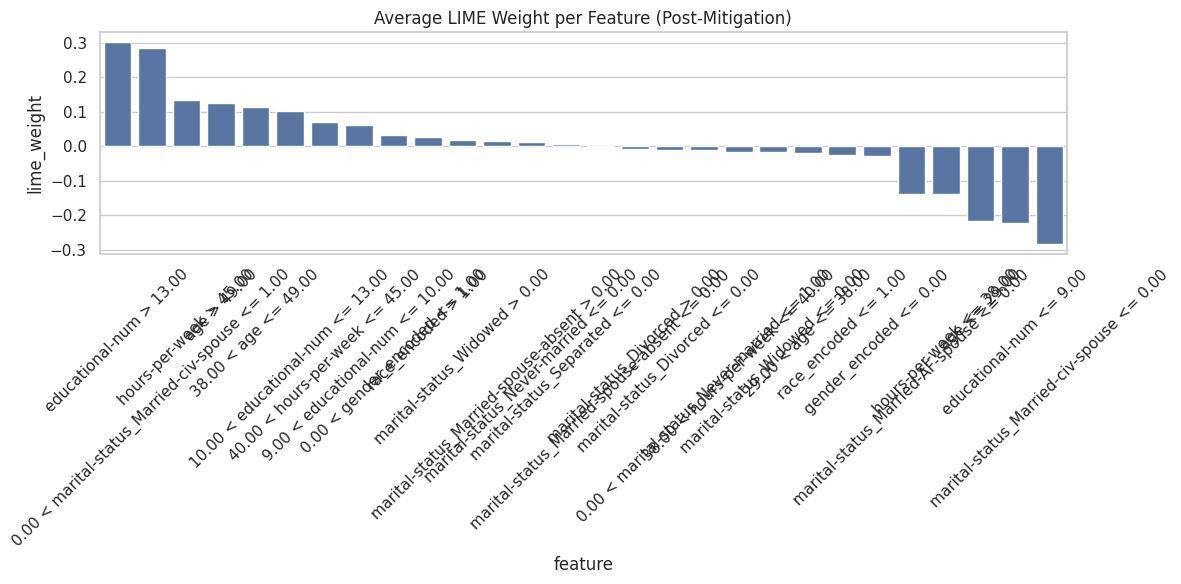

In [58]:
#LIME after reweighing
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_adult.values,
    feature_names=X_train_adult.columns.tolist(),
    class_names=['<=50K', '>50K'],
    mode='classification'
)

lime_weights = []
for i in range(30):
    exp = explainer.explain_instance(
        data_row=X_test_adult.values[i],
        predict_fn=model_xg_reweighted.predict_proba,
        num_features=10
    )
    for feature, weight in exp.as_list():
        lime_weights.append({'feature': feature, 'lime_weight': weight})

lime_df = pd.DataFrame(lime_weights)
avg_weights = lime_df.groupby('feature')['lime_weight'].mean().reset_index()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(x='feature', y='lime_weight', data=avg_weights.sort_values('lime_weight', ascending=False))
plt.title('Average LIME Weight per Feature (Post-Mitigation)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [59]:
#Apply SLM to reduce bias and also explain both prediction and bias after training in word
# Load tokenizer and phi-2 model
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2",
                                             torch_dtype=torch.float16,
                                             device_map="auto")





tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [60]:
import pandas as pd

# 1. Load the SHAP wide-format CSV for COMPAS
shap_df_compas = pd.read_csv("shap_values_compas_wide.csv")

# 2. Remove sample_id column
shap_only = shap_df_compas.drop(columns=["sample_id"])

# 3. Load test set and model to get predictions
# Make sure X_test_compas and rf_reweighted are defined in your environment

# 4. Extract top SHAP feature per sample
top_features = []

for i, row in shap_only.iterrows():
    top_feat = row.abs().idxmax()  # Feature with highest |SHAP value|
    shap_val = row[top_feat]

    # Get predicted label from the reweighted model
    pred = rf_reweighted.predict(X_test_compas.iloc[i:i+1])[0]
    pred_label = "Low Risk" if pred == 0 else "High Risk"

    top_features.append({
        "feature": top_feat,
        "shap_value": shap_val,
        "prediction_label": pred_label,
        "dataset": "COMPAS"
    })

# 5. Save to CSV
top_shap_df_compas = pd.DataFrame(top_features)
top_shap_df_compas.to_csv("shap_top_features_compas.csv", index=False)
print("Top SHAP features for COMPAS saved to shap_top_features_compas.csv")


Top SHAP features for COMPAS saved to shap_top_features_compas.csv


In [61]:
import pandas as pd

# Load SHAP wide-format for Adult
shap_df_adult = pd.read_csv("shap_values_adult.csv")

# Drop 'sample_id' if it exists
if 'sample_id' in shap_df_adult.columns:
    shap_only = shap_df_adult.drop(columns=["sample_id"])
else:
    shap_only = shap_df_adult.copy()

# Loop through and extract top feature per sample
top_features = []

for i, row in shap_only.iterrows():
    top_feat = row.abs().idxmax()
    shap_val = row[top_feat]

    # Get model prediction (make sure X_test_adult and model are available)
    pred = model_xg_reweighted.predict(X_test_adult.iloc[i:i+1])[0]
    pred_label = "<=50K" if pred == 0 else ">50K"

    top_features.append({
        "feature": top_feat,
        "shap_value": shap_val,
        "prediction_label": pred_label,
        "dataset": "Adult Income"
    })

# Save to CSV
pd.DataFrame(top_features).to_csv("shap_top_features_adult.csv", index=False)
print("Top SHAP features for Adult dataset saved to shap_top_features_adult.csv")


Top SHAP features for Adult dataset saved to shap_top_features_adult.csv


In [62]:
def generate_shap_prompt(feature, shap_value, prediction_label, dataset_name):
    return (
        f"In the {dataset_name} dataset, the feature '{feature}' had a SHAP value of {shap_value:.2f}, "
        f"and the model predicted '{prediction_label}'. Explain in simple terms how this feature influenced the prediction, "
        f"and whether it could reflect bias.\nExplanation:"
    )


In [63]:
def process_shap_dataframe(df, dataset_name, output_csv_name):
    explanations = []

    for idx, row in df.iterrows():
        prompt = generate_shap_prompt(
            row["feature"], row["shap_value"], row["prediction_label"], dataset_name
        )

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        outputs = model.generate(
            **inputs,
            max_length=150,
            temperature=0.4,
            top_p=0.9,
            do_sample=True
        )

        full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
        explanation_only = full_output[len(prompt):].strip()

        explanations.append({
            "feature": row["feature"],
            "shap_value": row["shap_value"],
            "prediction_label": row["prediction_label"],
            "dataset": dataset_name,
            "explanation": explanation_only
        })

        print(f" [{dataset_name}] Row {idx} processed.")

    # Save results
    pd.DataFrame(explanations).to_csv(output_csv_name, index=False)
    print(f"All explanations saved to {output_csv_name}")


In [ ]:
# Load the top SHAP feature files
shap_adult = pd.read_csv("shap_top_features_adult.csv")
shap_compas = pd.read_csv("shap_top_features_compas.csv")

# Process Adult
process_shap_dataframe(shap_adult, "Adult Income", "shap_values_adult_final.csv")

# Process COMPAS
process_shap_dataframe(shap_compas, "COMPAS", "shap_values_compas_final.csv")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 0 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 1 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 2 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 3 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 4 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 5 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 6 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 7 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 8 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 9 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 10 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 11 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 12 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 13 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 14 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 15 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 16 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 17 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 18 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 19 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 20 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 21 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 22 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 23 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 24 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 25 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 26 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 27 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 28 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 29 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 30 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 31 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 32 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 33 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 34 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 35 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 36 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 37 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 38 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 39 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 40 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 41 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 42 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 43 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 44 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 45 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 46 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 47 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 48 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 49 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 50 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 51 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 52 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 53 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 54 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 55 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 56 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 57 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 58 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 59 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 60 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 61 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 62 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 63 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 64 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 65 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 66 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 67 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 68 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 69 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 70 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 71 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 72 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 73 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 74 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 75 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 76 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 77 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 78 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 79 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 80 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 81 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 82 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 83 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 84 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 85 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 86 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 87 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 88 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 89 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 90 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 91 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 92 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 93 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 94 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 95 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 96 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 97 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 98 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 99 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 100 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 101 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 102 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 103 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 104 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 105 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 106 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 107 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 108 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 109 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 110 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 111 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 112 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 113 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 114 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 115 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 116 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 117 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 118 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 119 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 120 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 121 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 122 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 123 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 124 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 125 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 126 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 127 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 128 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 129 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 130 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 131 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 132 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 133 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 134 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 135 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 136 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 137 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 138 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 139 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 140 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 141 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 142 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 143 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 144 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 145 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 146 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 147 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 148 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 149 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 150 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 151 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 152 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 153 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 154 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 155 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 156 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 157 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 158 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 159 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 160 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 161 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 162 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 163 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 164 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 165 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 166 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 167 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 168 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 169 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 170 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 171 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 172 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 173 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 174 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 175 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 176 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 177 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 178 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 179 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 180 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 181 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 182 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 183 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 184 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 185 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 186 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 187 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 188 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 189 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 190 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 191 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 192 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 193 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 194 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 195 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 196 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 197 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 198 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 199 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 200 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 201 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 202 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 203 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 204 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 205 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 206 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 207 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 208 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 209 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 210 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 211 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 212 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 213 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 214 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 215 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 216 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 217 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 218 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 219 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 220 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 221 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 222 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 223 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 224 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 225 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 226 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 227 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 228 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 229 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 230 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 231 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 232 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 233 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 234 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 235 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 236 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 237 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 238 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 239 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 240 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 241 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 242 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 243 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 244 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 245 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 246 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 247 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 248 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 249 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 250 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 251 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 252 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 253 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 254 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 255 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 256 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 257 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 258 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 259 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 260 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 261 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 262 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 263 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 264 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 265 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 266 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 267 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 268 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 269 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 270 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 271 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 272 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 273 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 274 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 275 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 276 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 277 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 278 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 279 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 280 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 281 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 282 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 283 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 284 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 285 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 286 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 287 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 288 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 289 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 290 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 291 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 292 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 293 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 294 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 295 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 296 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 297 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 298 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 299 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 300 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 301 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 302 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 303 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 304 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 305 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 306 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 307 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 308 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 309 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 310 processed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [Adult Income] Row 311 processed.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>